In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import numpy as np
from scipy.stats import spearmanr, f_oneway

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern Roman']  # This is the default LaTeX font
plt.rcParams.update({'font.size': 16, 'axes.labelsize': 16, 'axes.titlesize': 16, 'legend.fontsize': 14})

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# Reading the data
df = pd.read_csv('current_analysis/xdbc_experiments_master.csv')
df.drop(columns=['client_readmode', 'table', 'host', 'date', 'run'], inplace=True)
df = df[df['time']>3]

In [39]:
filtered_df = df.copy()
filtered_df = filtered_df[
    (filtered_df["server_cpu"].isin([.2])) &
    (filtered_df["network"].isin([100])) &
    (filtered_df["system"] == "csv") &
    (filtered_df["bufpool_size"] == 1000) &
    (filtered_df["compression"] == "nocomp") &
    (filtered_df["format"] == 1) &
    (filtered_df["server_read_par"].isin([1])) &
    (filtered_df["server_read_partitions"].isin([1])) &
    (filtered_df["server_deser_par"].isin([1]))
    
]
filtered_df['environment'] = 'C' + filtered_df['client_cpu'].astype(str) + ' S' + filtered_df['server_cpu'].astype(str) + ' N' + filtered_df['network'].astype(str)
print(filtered_df.count())

system                    359
compression               359
format                    359
network_parallelism       359
bufpool_size              359
buff_size                 359
network                   359
client_cpu                359
client_read_par           359
client_decomp_par         359
server_cpu                359
server_read_par           359
server_read_partitions    359
server_deser_par          359
time                      359
datasize                  359
environment               359
dtype: int64


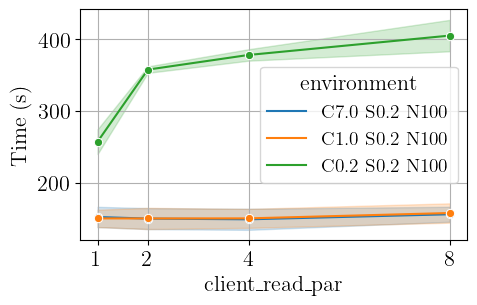

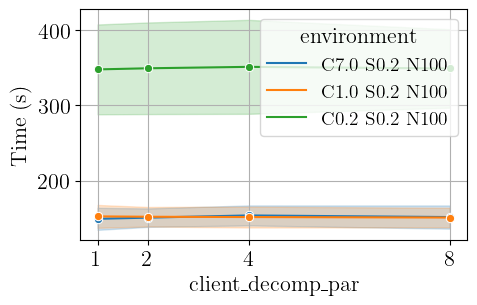

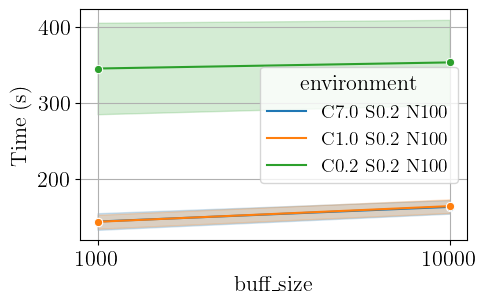

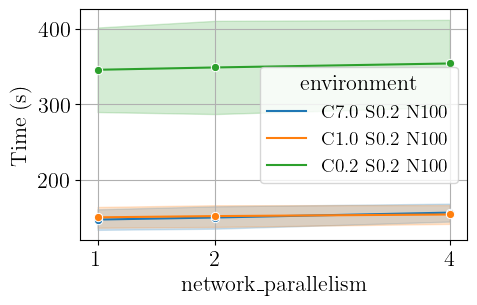

In [40]:
# Server parameters to plot
client_params = ["client_read_par", "client_decomp_par", "buff_size", "network_parallelism"]

for param in client_params:
    plt.figure(figsize=(5, 3))
    sns.lineplot(data=filtered_df, x=param, y="time", hue="environment", errorbar="sd", marker="o")
    #plt.title(f"Influence of {param} on performance")
    plt.ylabel("Time (s)")
    plt.xticks(filtered_df[param].unique())  # Set xticks to only have values present in the data
    plt.grid(True)
    #plt.savefig(f'paper_plots/average_{param}_for_weak_client.pdf', bbox_inches='tight')
    plt.show()

{'C7.0 S0.2 N100': {'client_read_par': 1,
  'client_decomp_par': 1,
  'buff_size': 1000,
  'network_parallelism': 1},
 'C1.0 S0.2 N100': {'client_read_par': 2,
  'client_decomp_par': 1,
  'buff_size': 1000,
  'network_parallelism': 2},
 'C0.2 S0.2 N100': {'client_read_par': 1,
  'client_decomp_par': 1,
  'buff_size': 1000,
  'network_parallelism': 2}}

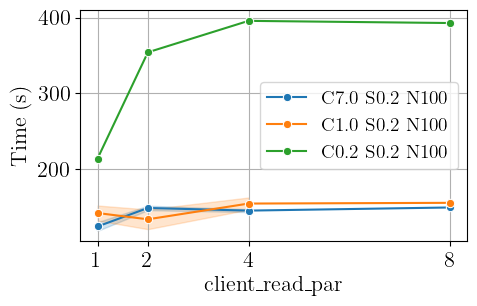

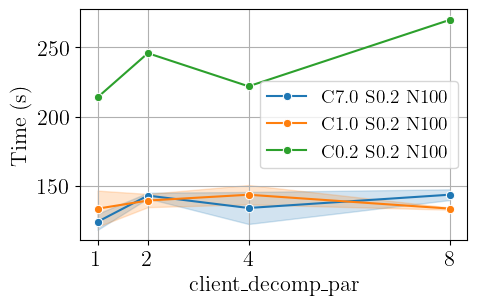

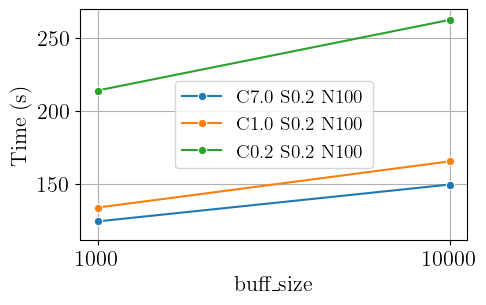

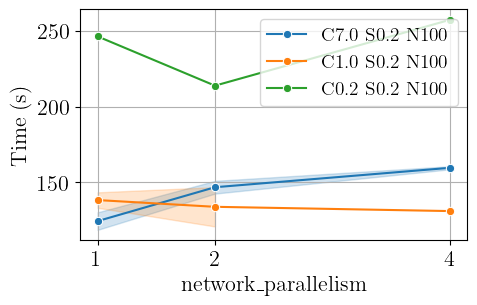

In [42]:
# Step 1: Determine the best parameter combinations for each environment
best_parameters_for_environment = {}

for env in filtered_df['environment'].unique():
    env_df = filtered_df[filtered_df['environment'] == env]
    # Sort by time and take the first row as the best configuration
    best_config = env_df.sort_values(by='time').iloc[0]
    best_params = {param: best_config[param] for param in client_params}
    best_parameters_for_environment[env] = best_params

display(best_parameters_for_environment)
# Step 2: Plotting
for param_to_vary in client_params:
    plt.figure(figsize=(5, 3))

    # For each environment, filter the data by the best parameters except the one to vary and plot
    for env, best_params in best_parameters_for_environment.items():
        subset_df = filtered_df[filtered_df['environment'] == env]
        
        for param, best_value in best_params.items():
            if param != param_to_vary:
                subset_df = subset_df[subset_df[param] == best_value]

        sns.lineplot(data=subset_df, x=param_to_vary, y="time", label=env, marker="o")
    
    #plt.title(f"Influence of {param_to_vary} on performance (other parameters fixed to best values)")
    plt.ylabel("Time (s)")
    plt.xticks(filtered_df[param_to_vary].unique())  # Set xticks to only have values present in the data
    plt.grid(True)
    plt.legend()
    plt.savefig(f'paper_plots/scaling_{param_to_vary}_for_weak_server.pdf', bbox_inches='tight')
    plt.show()


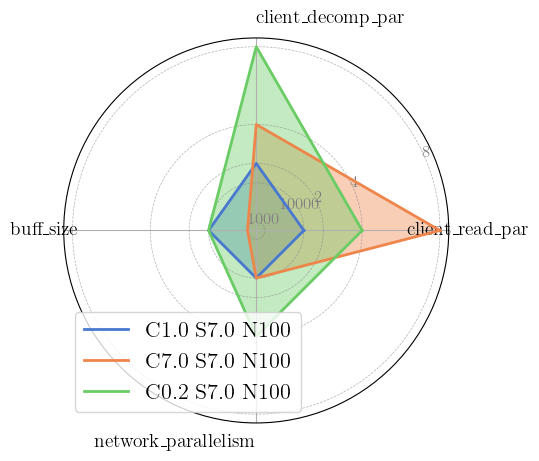

In [19]:
best_params_df = pd.DataFrame(best_parameters_for_environment).T
# Encoding buff_size
best_params_df['buff_size'] = best_params_df['buff_size'].replace({1000: -1, 10000: 1})

# Get dynamic index (unique environment configurations)
environments = filtered_df['environment'].unique()
best_params_df = best_params_df.reindex(environments)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, polar=True)

# Define a color palette and style
colors = sns.color_palette("muted", n_colors=len(best_params_df))
#plt.rc('font', family='Serif')  # Choose a readable font like 'Serif', 'Arial', etc.

# Draw one area plot for each environment
for i, env in enumerate(best_params_df.index):
    values = best_params_df.loc[env].tolist()
    values += values[:1]  # repeat the first value to close the circular graph
    angles = [n / float(len(client_params)) * 2 * np.pi for n in range(len(client_params))]
    angles += angles[:1]  # closing the plot
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=env, color=colors[i])
    ax.fill(angles, values, color=colors[i], alpha=0.4)  # Lowered alpha for overlay clarity

# Add a title and legend with enhanced settings
#plt.title("Optimal Server Parameters by Environment", size=20, y=1.1, fontweight='bold', color='black')
ax.legend(loc='best', fontsize='medium')

# Set labels for dimensions
ax.set_xticks(angles[:-1])
ax.set_xticklabels(client_params, fontsize=14, fontweight='normal', color='black')  # Set font properties

# Customize gridlines and yticks for better readability
ax.set_yticks([-1,1,2,4,8])  # You can set custom ticks based on your data range
ax.set_yticklabels(["1000","10000","2","4","8"], fontsize=12, color='grey', ha='center')
ax.yaxis.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.6)

# Place the y-labels closer to their respective lines to avoid overlap and enhance clarity
for label, angle in zip(ax.get_xticklabels(), angles):
    if angle in (0, np.pi):
        label.set_horizontalalignment('center')
    elif 0 < angle < np.pi:
        label.set_horizontalalignment('left')
    else:
        label.set_horizontalalignment('right')

# To show the available values for each dimension, you might consider adding annotations or secondary labels.
# This could complicate the plot, however, it's an approach to convey as much information as possible.

fig.savefig('paper_plots/best_client_config_for_strong_server.pdf', bbox_inches='tight')
plt.show()
